## Kaggle Competition for House Prices: Advanced Regression Techniques

In [63]:
#import libraries


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Check the train dataset

In [64]:
#import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Missing data inspection

Text(0.5, 1.0, 'TEST')

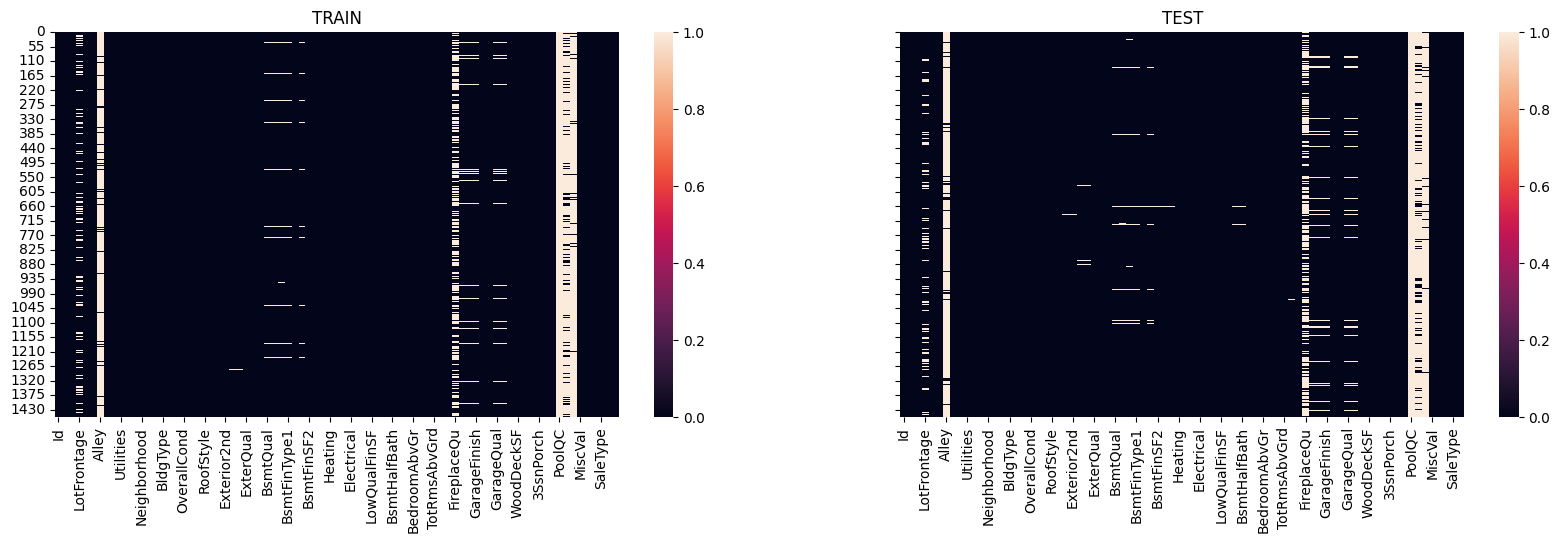

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

sns.heatmap(train.isnull(), ax=axes[0])
axes[0].set_title('TRAIN')

sns.heatmap(test.isnull(), ax=axes[1])
axes[1].set_title('TEST')

### Data preparation
##### N/A data cleaning

In [66]:
train.info

<bound method DataFrame.info of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Ut

In [67]:
#lets create two new dataframes without null-values
train_ready = pd.DataFrame()
test_ready = pd.DataFrame()
def NullHandling(feature):
    #print(feature)
    nulls = train[feature].isnull().sum() + test[feature].isnull().sum()
    print(feature, ' has ', nulls, ' nulls')
    if nulls == 0:
        print(feature, ' is fine')
        train_ready[feature] = train[feature]
        test_ready[feature] = test[feature]
    else :
        if nulls > 1500:
                print(feature, ' was dropped')
        else:
            if str(train[feature].squeeze().dtype) == 'object':
                train_ready[feature] = train[feature].fillna(train[feature].mode()[0])
                test_ready[feature] = test[feature].fillna(test[feature].mode()[0])
                print(feature, ' filled with mode-values')
            else:
                train_ready[feature] = train[feature].fillna(train[feature].mean())
                test_ready[feature] = test[feature].fillna(test[feature].mean())
                print(feature, ' missing values were filled by mean-value')
                 
features = list(train.columns)
features.pop()
for feature in features:
    NullHandling(feature=feature)


Id  has  0  nulls
Id  is fine
MSSubClass  has  0  nulls
MSSubClass  is fine
MSZoning  has  4  nulls
MSZoning  filled with mode-values
LotFrontage  has  486  nulls
LotFrontage  missing values were filled by mean-value
LotArea  has  0  nulls
LotArea  is fine
Street  has  0  nulls
Street  is fine
Alley  has  2721  nulls
Alley  was dropped
LotShape  has  0  nulls
LotShape  is fine
LandContour  has  0  nulls
LandContour  is fine
Utilities  has  2  nulls
Utilities  filled with mode-values
LotConfig  has  0  nulls
LotConfig  is fine
LandSlope  has  0  nulls
LandSlope  is fine
Neighborhood  has  0  nulls
Neighborhood  is fine
Condition1  has  0  nulls
Condition1  is fine
Condition2  has  0  nulls
Condition2  is fine
BldgType  has  0  nulls
BldgType  is fine
HouseStyle  has  0  nulls
HouseStyle  is fine
OverallQual  has  0  nulls
OverallQual  is fine
OverallCond  has  0  nulls
OverallCond  is fine
YearBuilt  has  0  nulls
YearBuilt  is fine
YearRemodAdd  has  0  nulls
YearRemodAdd  is fine
Roof

#### lets check amount of null-values in new datafrmes

Text(0.5, 1.0, 'TEST(NEW)')

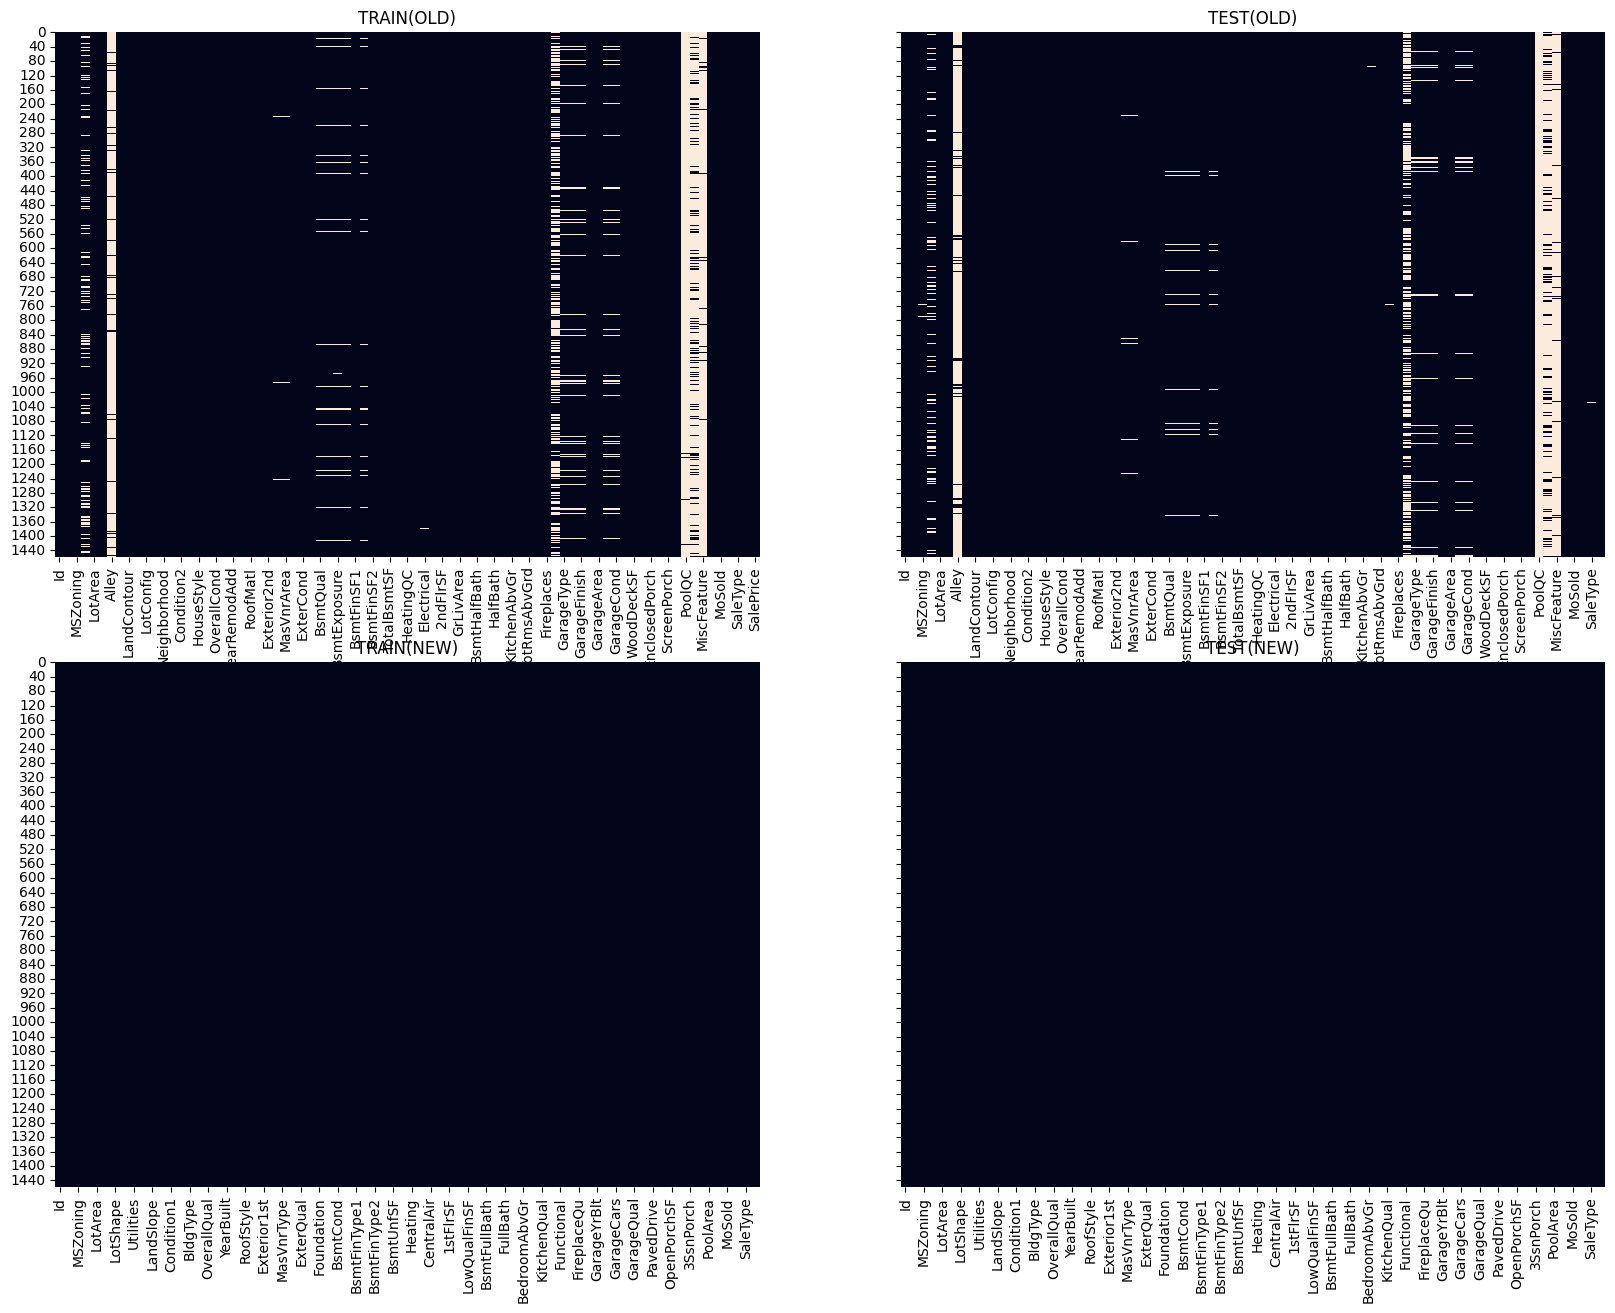

In [68]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15), sharey=True)

sns.heatmap(train.isnull(), ax=axes[0, 0], cbar=False)
axes[0, 0].set_title('TRAIN(OLD)')
sns.heatmap(test.isnull(), ax=axes[0, 1], cbar=False)
axes[0, 1].set_title('TEST(OLD)')
sns.heatmap(train_ready.isnull(), ax=axes[1, 0], cbar=False)
axes[1, 0].set_title('TRAIN(NEW)')
sns.heatmap(test_ready.isnull(), ax=axes[1, 1], cbar=False)
axes[1, 1].set_title('TEST(NEW)')

Data is cleared!!!!

In [69]:
# add house prices to train set
train_ready['SalePrice'] = train['SalePrice']

#rename train_ready and test_ready to train an test
train = train_ready
test = test_ready


##### Categorical data handling

In [70]:
#lets get a list of features with categorical data
features = list(test.columns)
cat_features = []
for feature in features:
    if str(test[feature].squeeze().dtype) == 'object':
        cat_features.append(feature)
print(cat_features, len(cat_features))


['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'] 39


In [71]:
#one-hot encoding
def CategoryHandling(dataframe, feature):
    values = dataframe[feature].unique()
    for value in values:
        name = str(feature) + ':' + str(value)
        dataframe.loc[dataframe[feature]==value, name] = 1
        dataframe.loc[dataframe[feature]!=value, name] = 0
        dataframe.drop(columns=[feature])

#prepare train-set
for feature in cat_features:
    CategoryHandling(dataframe=train, feature=feature)
train.drop(columns=cat_features, inplace=True)

#prepare test-set
for feature in cat_features:
    CategoryHandling(dataframe=test, feature=feature)
test.drop(columns=cat_features, inplace=True)

C:\Users\ostap\AppData\Local\Temp\ipykernel_16684\475219310.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe.loc[dataframe[feature]==value, name] = 1
C:\Users\ostap\AppData\Local\Temp\ipykernel_16684\475219310.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe.loc[dataframe[feature]==value, name] = 1
C:\Users\ostap\AppData\Local\Temp\ipykernel_16684\475219310.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

In [72]:
print(train.shape, test.shape)

(1460, 277) (1459, 260)


In [73]:
try:
    train.drop(columns=cat_features)
    test.drop(columns=cat_features)
except:
    pass
print(train.shape, test.shape)

(1460, 277) (1459, 260)


As we see train and test sets have different number of features. It must be becouse of different sets of values in categorical features. Lets check is there is any features in test dataframe that is not presented in train dataframe

In [74]:
train_features = list(train.columns)
test_features = list(test.columns)
lonely_features = []
for feature in test_features:
    if feature in train_features:
        pass
    else:
        lonely_features.append(feature)

print(lonely_features)

[]


As 'lonely_features' is empty - data preparation is finished.

### Model learning

In [75]:
test.to_csv('FormulatedTest.csv', index=False)

In [76]:
print(train.shape, test.shape)

(1460, 277) (1459, 260)


In [77]:
X = train.drop(['SalePrice'], axis=1)
Y = train['SalePrice']

In [78]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, Y)
#model fitted

LinearRegression()

In [82]:
# filling the missing features into 'test'
for feature in list(train.columns):
    if feature not in list(test.columns):
        test[feature] =  0
        print(feature)
    else: 
        pass
# test.drop(['SalePrice'], axis=1)
print(train.shape, test.shape)
# x = test
# y = model.predict(x)
# y

SalePrice
Utilities:NoSeWa
Condition2:RRNn
Condition2:RRAn
Condition2:RRAe
HouseStyle:2.5Fin
RoofMatl:Metal
RoofMatl:Membran
RoofMatl:Roll
RoofMatl:ClyTile
Exterior1st:Stone
Exterior1st:ImStucc
Exterior2nd:Other
Heating:OthW
Heating:Floor
Electrical:Mix
GarageQual:Ex
(1460, 277) (1459, 277)


C:\Users\ostap\AppData\Local\Temp\ipykernel_16684\4167052254.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[feature] =  0
C:\Users\ostap\AppData\Local\Temp\ipykernel_16684\4167052254.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[feature] =  0
C:\Users\ostap\AppData\Local\Temp\ipykernel_16684\4167052254.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axi